
# Linear and Quadratic Discriminant Analysis with covariance ellipsoid

This example plots the covariance ellipsoids of each class and the decision boundary
learned by :class:`~sklearn.discriminant_analysis.LinearDiscriminantAnalysis` (LDA) and
:class:`~sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis` (QDA). The
ellipsoids display the double standard deviation for each class. With LDA, the standard
deviation is the same for all the classes, while each class has its own standard
deviation with QDA.


In [1]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

## Data generation

First, we define a function to generate synthetic data. It creates two blobs centered
at `(0, 0)` and `(1, 1)`. Each blob is assigned a specific class. The dispersion of
the blob is controlled by the parameters `cov_class_1` and `cov_class_2`, that are the
covariance matrices used when generating the samples from the Gaussian distributions.



In [2]:
import numpy as np


def make_data(n_samples, n_features, cov_class_1, cov_class_2, seed=0):
    rng = np.random.RandomState(seed)
    X = np.concatenate(
        [
            rng.randn(n_samples, n_features) @ cov_class_1,
            rng.randn(n_samples, n_features) @ cov_class_2 + np.array([1, 1]),
        ]
    )
    y = np.concatenate([np.zeros(n_samples), np.ones(n_samples)])
    return X, y

We generate three datasets. In the first dataset, the two classes share the same
covariance matrix, and this covariance matrix has the specificity of being spherical
(isotropic). The second dataset is similar to the first one but does not enforce the
covariance to be spherical. Finally, the third dataset has a non-spherical covariance
matrix for each class.



In [3]:
covariance = np.array([[1, 0], [0, 1]])
X_isotropic_covariance, y_isotropic_covariance = make_data(
    n_samples=1_000,
    n_features=2,
    cov_class_1=covariance,
    cov_class_2=covariance,
    seed=0,
)
covariance = np.array([[0.0, -0.23], [0.83, 0.23]])
X_shared_covariance, y_shared_covariance = make_data(
    n_samples=300,
    n_features=2,
    cov_class_1=covariance,
    cov_class_2=covariance,
    seed=0,
)
cov_class_1 = np.array([[0.0, -1.0], [2.5, 0.7]]) * 2.0
cov_class_2 = cov_class_1.T
X_different_covariance, y_different_covariance = make_data(
    n_samples=300,
    n_features=2,
    cov_class_1=cov_class_1,
    cov_class_2=cov_class_2,
    seed=0,
)

## Plotting Functions

The code below is used to plot several pieces of information from the estimators used,
i.e., :class:`~sklearn.discriminant_analysis.LinearDiscriminantAnalysis` (LDA) and
:class:`~sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis` (QDA). The
displayed information includes:

- the decision boundary based on the probability estimate of the estimator;
- a scatter plot with circles representing the well-classified samples;
- a scatter plot with crosses representing the misclassified samples;
- the mean of each class, estimated by the estimator, marked with a star;
- the estimated covariance represented by an ellipse at 2 standard deviations from the
  mean.



In [4]:
import matplotlib as mpl
from matplotlib import colors

from sklearn.inspection import DecisionBoundaryDisplay


def plot_ellipse(mean, cov, color, ax):
    v, w = np.linalg.eigh(cov)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(
        mean,
        2 * v[0] ** 0.5,
        2 * v[1] ** 0.5,
        angle=180 + angle,
        facecolor=color,
        edgecolor="black",
        linewidth=2,
    )
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.4)
    ax.add_artist(ell)


def plot_result(estimator, X, y, ax):
    cmap = colors.ListedColormap(["tab:red", "tab:blue"])
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="predict_proba",
        plot_method="pcolormesh",
        ax=ax,
        cmap="RdBu",
        alpha=0.3,
    )
    DecisionBoundaryDisplay.from_estimator(
        estimator,
        X,
        response_method="predict_proba",
        plot_method="contour",
        ax=ax,
        alpha=1.0,
        levels=[0.5],
    )
    y_pred = estimator.predict(X)
    X_right, y_right = X[y == y_pred], y[y == y_pred]
    X_wrong, y_wrong = X[y != y_pred], y[y != y_pred]
    ax.scatter(X_right[:, 0], X_right[:, 1], c=y_right, s=20, cmap=cmap, alpha=0.5)
    ax.scatter(
        X_wrong[:, 0],
        X_wrong[:, 1],
        c=y_wrong,
        s=30,
        cmap=cmap,
        alpha=0.9,
        marker="x",
    )
    ax.scatter(
        estimator.means_[:, 0],
        estimator.means_[:, 1],
        c="yellow",
        s=200,
        marker="*",
        edgecolor="black",
    )

    if isinstance(estimator, LinearDiscriminantAnalysis):
        covariance = [estimator.covariance_] * 2
    else:
        covariance = estimator.covariance_
    plot_ellipse(estimator.means_[0], covariance[0], "tab:red", ax)
    plot_ellipse(estimator.means_[1], covariance[1], "tab:blue", ax)

    ax.set_box_aspect(1)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.set(xticks=[], yticks=[])

## Comparison of LDA and QDA

We compare the two estimators LDA and QDA on all three datasets.



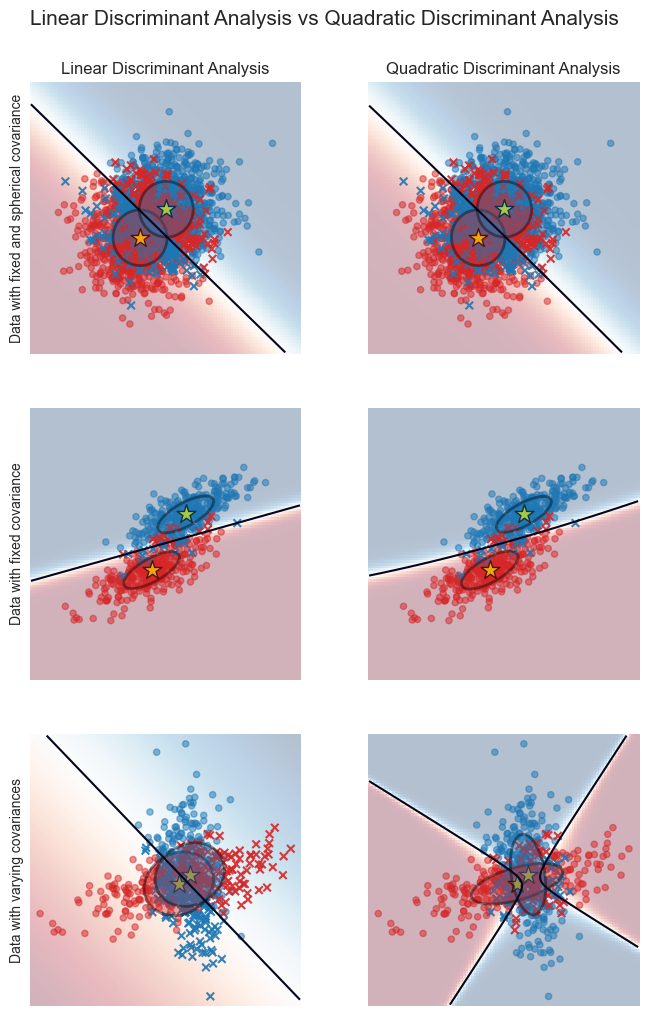

In [5]:
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import (
    LinearDiscriminantAnalysis,
    QuadraticDiscriminantAnalysis,
)

fig, axs = plt.subplots(nrows=3, ncols=2, sharex="row", sharey="row", figsize=(8, 12))

lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
qda = QuadraticDiscriminantAnalysis(store_covariance=True)

for ax_row, X, y in zip(
    axs,
    (X_isotropic_covariance, X_shared_covariance, X_different_covariance),
    (y_isotropic_covariance, y_shared_covariance, y_different_covariance),
):
    lda.fit(X, y)
    plot_result(lda, X, y, ax_row[0])
    qda.fit(X, y)
    plot_result(qda, X, y, ax_row[1])

axs[0, 0].set_title("Linear Discriminant Analysis")
axs[0, 0].set_ylabel("Data with fixed and spherical covariance")
axs[1, 0].set_ylabel("Data with fixed covariance")
axs[0, 1].set_title("Quadratic Discriminant Analysis")
axs[2, 0].set_ylabel("Data with varying covariances")
fig.suptitle(
    "Linear Discriminant Analysis vs Quadratic Discriminant Analysis",
    y=0.94,
    fontsize=15,
)
plt.show()

The first important thing to notice is that LDA and QDA are equivalent for the
first and second datasets. Indeed, the major difference is that LDA assumes
that the covariance matrix of each class is equal, while QDA estimates a
covariance matrix per class. Since in these cases the data generative process
has the same covariance matrix for both classes, QDA estimates two covariance
matrices that are (almost) equal and therefore equivalent to the covariance
matrix estimated by LDA.

In the first dataset the covariance matrix used to generate the dataset is
spherical, which results in a discriminant boundary that aligns with the
perpendicular bisector between the two means. This is no longer the case for
the second dataset. The discriminant boundary only passes through the middle
of the two means.

Finally, in the third dataset, we observe the real difference between LDA and
QDA. QDA fits two covariance matrices and provides a non-linear discriminant
boundary, whereas LDA underfits since it assumes that both classes share a
single covariance matrix.

